# This code takes in the W99 quadratic fits and applies them to the 361x361 grid

In [2]:
import pandas as pd
import numpy as np
import xarray as xr
from field_importer import get_field
import pickle
import numpy.ma as ma
from cartoplot import cartoplot
import mask
from tqdm import trange
from math import sin, cos, sqrt, radians
import os
from netCDF4 import Dataset
import matplotlib.pyplot as plt

# Define the functions

In [2]:
def W99_grid_maker(lon_grid,lat_grid,land_mask=None):
    
    """This function takes a pair of lon/lat grids
    and projects the W99 snow climatology over them"""

    monthlist = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

    #initiate empty arrays to put the x and y coords in

    xarray = np.zeros(lon_grid.shape)
    yarray = np.zeros(lon_grid.shape)

    #convert the polar coords (lon, lat) to x, y
    
    print('Making Grid')
    
    for i in trange(lon_grid.shape[0]):
        for j in range(lon_grid.shape[1]):
            if land_mask[i,j] == 1:
                pass
            else:
    #         for each point on the EASE grid, calculate x and y coordinates
                xarray[i,j] = (90-lat_grid[i,j]) * cos(radians(lon_grid[i,j]))
                yarray[i,j] = (90-lat_grid[i,j]) * sin(radians(lon_grid[i,j]))
    
    return(xarray,yarray)

def W99_projector(xarray,yarray,land_mask=None):
    
    monthlist = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
  
    print('Grid Made')

    #import the W99 coefficients for SWE and depth
    
    print('Importing W99 Coeffs')
    
    path ='Warren_climatology.xlsx'
    SWE_data = pd.read_excel(path,sheet_name="SWE",index_col=0)
    depth_data = pd.read_excel(path,sheet_name="depth",index_col=0)

    #initialise empty arrays in which to put variables

    SWE_array = np.zeros((13,xarray.shape[0],xarray.shape[1]))
    depth_array = np.zeros((13,xarray.shape[0],xarray.shape[1]))
    
    SWE_array[:,:], depth_array[:,:] = np.nan,np.nan
    
    data_dict = {"depth":depth_array,"SWE":SWE_array}
    
    print('Starting Projection')

    for i in trange(xarray.shape[0]):
        for j in range(xarray.shape[1]):
            
            if land_mask[i,j] == 1:
                
                pass
            
            else:

                x = xarray[i,j] 
                y = yarray[i,j]

                #   get x and y coords


                xx = x**2
                yy = y**2
                xy = x*y

                for month in monthlist:

        #             get the fit coefficients for the selected month
                    dcoeffs = depth_data.loc[int(month)]
                    Scoeffs = SWE_data.loc[int(month)]

        #             use the coefficients and xy coordinates to calculate depth and SWE
        
                    # Divide depth by 100 to get meters
        
                    data_dict['depth'][int(month),i,j] = (dcoeffs["H0"] + dcoeffs["A"]*x + dcoeffs["B"]*y +
                                                          dcoeffs["C"]*xy + dcoeffs["D"]*(xx) +
                                                          dcoeffs["E"]*(yy))/100
            
                    # Multiply SWE in cm by 10 to get kg (1000km3 water density)
                    
                    data_dict['SWE'][int(month),i,j] = (Scoeffs["H0"] + Scoeffs["A"]*x + Scoeffs["B"]*y +
                                                        Scoeffs["C"]*xy + Scoeffs["D"]*(xx) +
                                                        Scoeffs["E"]*(yy))*10
    
    
    
    
    return(data_dict)

def import_OSISAF_grid(year='2012',
                       month='02',
                       folder = '/home/robbie/Dropbox/Data/OSISAF_type/Monthly_means/'):
    
    filename = year + month + "monmean.nc"
    data = Dataset(folder+filename)

    lons = np.array(data['lon'])
    lats = np.array(data['lat'])
    
    return(data)

# Now run the function over the 361x361 Grid

In [3]:
# Create a land mask to speed up the code

mask_data = mask.get("mask")
zeros_array = np.full((361,361),0)
land_mask = ma.masked_where(mask_data == 20, zeros_array)
land_mask = np.ma.filled(land_mask.astype(float), 1)

#Put the grid into the fuction

arrays = W99_grid_maker(mask.get('lon'),mask.get('lat'),land_mask)

W99 = W99_projector(arrays[0],arrays[1],land_mask)

# Now save to netcdf

monthlist_ints = list(range(0,13))

print(monthlist_ints)

ds = xr.Dataset( data_vars={'depth':(['t','x','y'], W99['depth']),
                            'SWE':(['t','x','y'], W99['SWE'])},

                     coords={'lon':(['x','y'],mask.get('lon')),
                             'lat':(['x','y'],mask.get('lat')),
                             'month':(['t'],monthlist_ints)})

data_dir = '/home/robbie/Dropbox/SM_Thickness/data/W99/'

ds.to_netcdf(f'{data_dir}W99_361.nc','w')

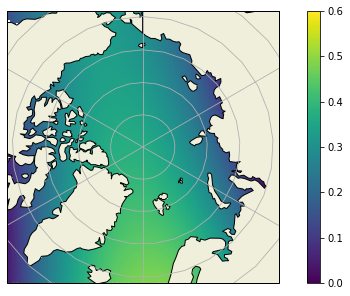

In [9]:
data = get_field('W99',month="04",year="2012",resolution=361,variable='depth')

cartoplot(mask.get('lon'),mask.get('lat'),data['field'],color_scale=(0,0.6))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


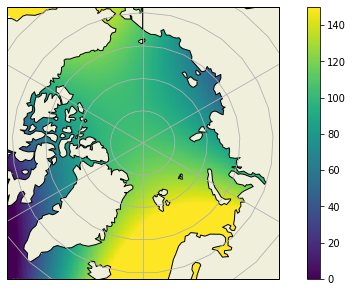

In [9]:
cartoplot(mask.get('lon'),mask.get('lat'),W99['SWE'][3],color_scale=(0,150))

# Now test the W99 file we've made

In [38]:
# help(cartoplot)
# print(data)

W99_data = pickle.load(open("W99_760.p","rb"))
print(W99_data['depth'].shape)

W99_data = pickle.load(open("W99_361.p","rb"))
print(W99_data['depth'].shape)

W99_data = pickle.load(open("W99+OSISAF.p","rb"))


(13, 1120, 760)
(13, 361, 361)


In [39]:
W99_data = pickle.load(open("W99_720.p","rb"))
print(W99_data['depth'].shape)

print(W99_data.keys())

# for i in range(1,12):
#     cartoplot.cartoplot(data['lon'],
#                         data['lat'],
#                         W99_data['depth'][i],
#                         ocean=False,
#                         color_scale=(0,0.6))

FileNotFoundError: [Errno 2] No such file or directory: 'W99_720.p'